# Parameter Namespaces

We can defined namespaces using `NS(<namespace_name>)` notation in parameter declarations and expressions:

In [1]:
from qupulse.pulses import TablePT
entry_list = [(0, 0),
              ('NS(simple_pulse).tx', 'NS(simple_pulse).x', 'hold'),
              ('NS(simple_pulse).ty', 'NS(simple_pulse).y', 'linear'),
              ('NS(all_pulses).t_end', 0, 'jump')]
entries = {0: entry_list}

simple_pulse_pt = TablePT(entries)
print(simple_pulse_pt.parameter_names)

C:\Users\prediger\AppData\Local\Continuum\miniconda3\envs\qupulse-devel\lib\site-packages\qupulse\utils\sympy.py:19: UserWarning: scipy is not installed. This reduces the set of available functions to those present in numpy + manually vectorized functions in math.
  warnings.warn('scipy is not installed. This reduces the set of available functions to those present in numpy + '


{'NS(simple_pulse).ty', 'NS(all_pulses).t_end', 'NS(simple_pulse).x', 'NS(simple_pulse).tx', 'NS(simple_pulse).y'}


For instantiating, we pass a nested dictionary

<IPython.core.display.Javascript object>


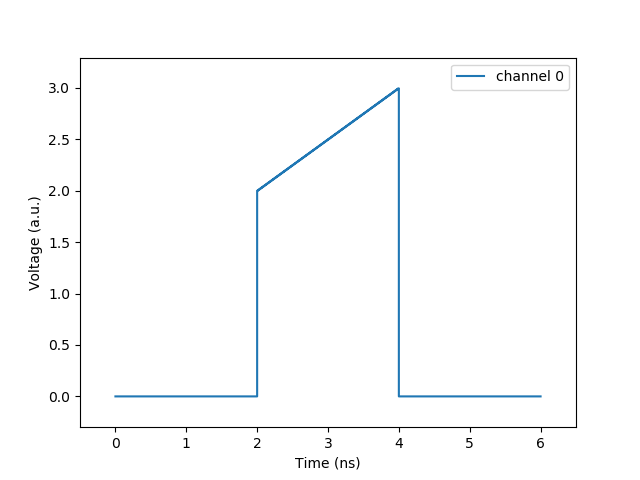

In [2]:
parameters = {'simple_pulse': {'tx': 2, 'ty': 4, 'x': 2, 'y': 3}, 'all_pulses': {'t_end': 6}}

%matplotlib notebook
from qupulse.pulses.plotting import plot

_ = plot(simple_pulse_pt, parameters=parameters, sample_rate=100)

It is also possible to pass a flat dictionary with fully namespaces parameter names as keys:

<IPython.core.display.Javascript object>


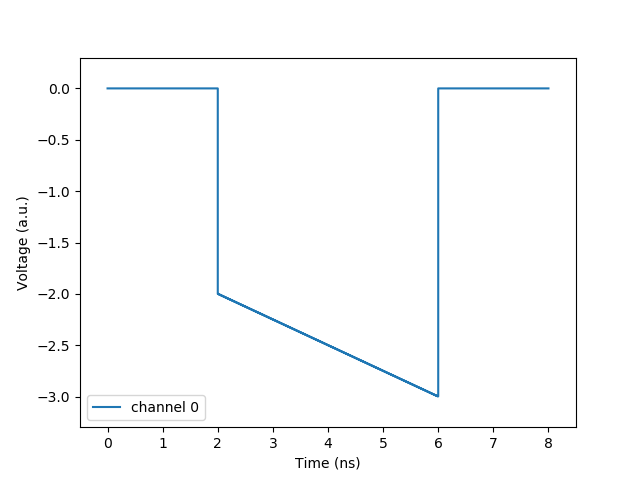

In [3]:
parameters = {'NS(simple_pulse).tx': 2, 'NS(simple_pulse).ty': 6, 'NS(simple_pulse).x': -2, 'NS(simple_pulse).y': -3, 'NS(all_pulses).t_end': 8}

_ = plot(simple_pulse_pt, parameters=parameters, sample_rate=100)

(__developer internal info__) In fact the nested version will be transformed into the flat version by `PulseTemplate.create_program` using `utils.sympy.flatten_parameter_dict` before the parameter dictionary is passed on to `PulseTemplate._internal_create_program`. All functionality currently essentially operates on the flat dictionary.

## Mapping

`MappingPT` can deal with namespaces. It allows explicit mapping of any namespaced parameter to anything else and it allows wholesale mapping of namespaces. Explicit parameter mapping takes precedence over namespace mapping.

In [4]:
from qupulse.pulses import MappingPT
from qupulse.utils.sympy import NS

parameter_mapping = {'NS(simple_pulse).tx': 'NS(generics).NS(times).t_begin', 
                     'NS(simple_pulse).x': 't*k',
                     'NS(all_pulses).t_end': 't_end'}
namespace_mapping = {'NS(simple_pulse)': 'NS(experiment).NS(qubit1).NS(simple_pulse)'}
mapped_pt = MappingPT(simple_pulse_pt, parameter_mapping=parameter_mapping, namespace_mapping=namespace_mapping)
print(mapped_pt.parameter_names)

{'k', 't_end', 'NS(experiment).NS(qubit1).NS(simple_pulse).ty', 'NS(generics).NS(times).t_begin', 'NS(experiment).NS(qubit1).NS(simple_pulse).y', 't'}


<IPython.core.display.Javascript object>


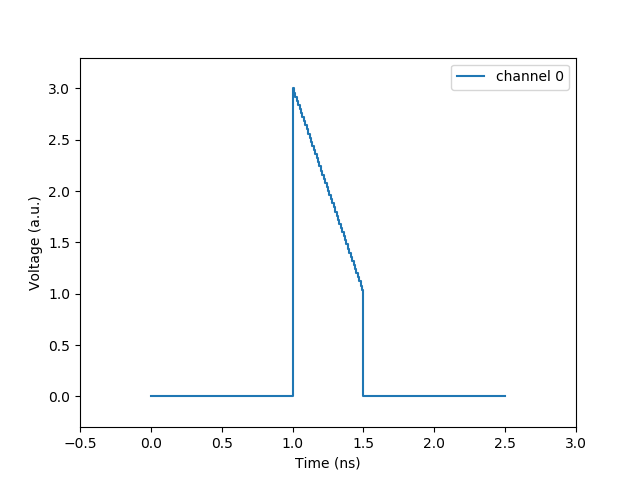

In [5]:
parameters = {'experiment': {'qubit1': {'simple_pulse': {'ty': 1.5, 'y': 1}}}, 
              'generics': {'times': {'t_begin': 1}},
              't': 2,
              'k': 1.5,
              't_end': 2.5}

_ = plot(mapped_pt, parameters=parameters, sample_rate=100)

Explicit mapping requires full namespace notation in the parameter dictionary and currently does not allow for nested dicts, i.e. in the above it is not possible to defined the `parameter_mapping` as `{'simple_pulse': {'tx': 'NS(generic).NS(times).t_begin'....` and so forth.
Namespace mapping also crucially requires the `NS(<namespace name>)` notation on both sides of each mapping. It is obviously required that namespaces are always mapped to namespaces, not to parameters, i.e., the `namespace_mapping` cannot have statements of the form

- `'NS(foo)': 'k'`
- `'NS(foo)': 'NS(bar).param'`

are not allowed.
It is currently also required that all mapping entries are strings.

A nested namespace `NS(foo).NS(bar)` will not be mapped by a mapping for `NS(bar)` but will be affected for mappings of `NS(foo).NS(bar)` and `NS(foo)`:

- mapping `NS(foo).NS(bar)` with mapping `NS(foo).NS(bar): NS(other)` results in `NS(other)`
- mapping `NS(foo).NS(bar)` with mapping `NS(foo): NS(other)` results in `NS(other).NS(bar)`
- mapping `NS(foo).NS(bar)` with mapping `NS(bar): NS(other)` results in `NS(foo).NS(bar)` (no change)

Providing mapping for both outer and nested namespace (i.e., `NS(foo).NS(bar): NS(other1)` _and_ `NS(foo): NS(other2)`) currently results in undefined behavior (and may produce either `NS(other1)` _or_ `NS(other2).NS(bar)` depending on the order in which the mappings are processed, which is currently not specified.